# Setup and install for Test13

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install gpflow
%pip install plotnine
%pip install plotly

     |████████████████████████████████| 286 kB 14.6 MB/s 


In [4]:
%pip install keras_self_attention
%pip install keras-tuner
%pip install pycm

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=614cea7ac58110ab7dbf85a16206692a92c4b6e77fcc58dfbb6c0b42e4f23365
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention
     |████████████████████████████████| 98 kB 6.3 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 580 kB 34.2 MB/s 


In [5]:
from plotnine import *
from plotnine.themes import *
import plotly as py
import plotly.graph_objs as go
import pandas as pd


In [6]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, Input,Multiply
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import SimpleRNN, GRU, LeakyReLU
from tensorflow.keras.layers import Concatenate, Average 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  Bidirectional
from timeit import default_timer as timer
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import random
import warnings
import gpflow
from gpflow.utilities import ops, print_summary, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter
import warnings
from functools import partial
from multiprocessing import Pool, cpu_count
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from tensorflow.keras import regularizers
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import keras_tuner as kt

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [8]:
paper_name = "test13"

In [9]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_tb/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


This will use the Test13 dataset

* A. Fiannaca, M. La Rosa, L. La Paglia, R. Rizzo, and A. Urso. Nrc: Non-coding rna classifier based on structural features. BioData Mining, 10, 08 2017. doi: 10.1186/s13040-017-0148-2.

The orginal loading of the data is from : e2e_dataprocess_from_fasta_example.ipynb



In [10]:
data_location = f'/content/drive/MyDrive/data_papers/{paper_name}'

In [11]:
# Run this cell to load the dataset
INPUT_DIM = 8    # 

hf_Train = h5.File(f'{data_location}/Fold_10_Train_Data_1000.h5', 'r')
hf_Test = h5.File(f'{data_location}/Fold_10_Test_Data_1000.h5', 'r')

X_train = hf_Train['Train_Data'] # Get train set
X_train = np.array(X_train)
Y_train = hf_Train['Label']      # Get train label
Y_train = np.array(Y_train)

X_test = hf_Test['Train_Data']     # Get test set
X_test = np.array(X_test)
Y_test = hf_Test['Label']       # Get test label
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, 13)  # Process the label of tain
Y_test = to_categorical(Y_test, 13)    #  Process the label of te

def coShuffled_vectors(X,Y):
    if tf.shape(X)[0] ==  tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return ( tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs) )
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")

X_test_shuffled, Y_test_shuffled = coShuffled_vectors(np.array(hf_Test['Train_Data']), to_categorical(np.array(hf_Test['Label']),13))
X_train_shuffled, Y_train_shuffled = coShuffled_vectors(np.array(hf_Train['Train_Data']), to_categorical(np.array(hf_Train['Label']),13))



In [12]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')] 
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='upper right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()



In [13]:

def get_layer_by_name(layers, name, return_first = True):
    matching_named_layers = [ l for l in layers if l.name==name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def get_combined_features_from_models(
        to_combine, 
        X_train, Y_train, 
        X_test, Y_test,
        reverse_one_hot = False,
        normalize_X_func = None):
    
    models = dict()
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))
    
    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1  
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1 
    else:
        Y_train_new = Y_train.copy()
        Y_test_new = Y_test.copy()
    
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models.keys():
                model_here = models[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name, **kwargs) if kwargs is not None else tf.keras.models.load_model(model_file_name)
        features_model = Model(model_here.input, 
                               get_layer_by_name(model_here.layers,layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test)), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models[model_file_name] = model_here            
        
    X_train_new = np.concatenate(tuple(X_trains_out), axis = 1)
    X_test_new = np.concatenate(tuple(X_test_out), axis = 1)
    
    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)    
    
        
    return (models, data_train, data_test,XY_dict)



In [14]:
def run_and_save_model(model_func, X_train, Y_train, kwargs):    
    m = model_func()
    m.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, **kwargs) 
    m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


In [15]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, LeakyReLU, MaxPooling1D, BatchNormalization, GaussianNoise, Dropout, Dense, Flatten
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kerastuner as kt
from kerastuner import HyperModel
import numpy as np
import itertools
import multiprocessing
from numpy import genfromtxt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from pycm import ConfusionMatrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



In [16]:
data_location

'/content/drive/MyDrive/data_papers/test13'

In [17]:

def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")

def reverse_one_hot(Y_input):
    return np.apply_along_axis(np.argmax, 1, Y_input) + 1

def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])

def prf(model,xtest, ytest):
  y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
  y_true = np.apply_along_axis(np.argmax, 1, ytest)
  return precision_recall_fscore_support(y_true, y_pred, average="weighted")

def get_sp_pr_rc_f1(model,xtest, ytest):  
    y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
    y_true = np.apply_along_axis(np.argmax, 1, ytest)
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    return cmres.TNR_Macro, pr, rc, f1
 
def get_sp_pr_rc_f1_acc(model,xtest, ytest):  
    spec, pr, rc, f1 = get_sp_pr_rc_f1(model,xtest, ytest)
    acc = model.evaluate(xtest,ytest)[-1]        
    return spec, pr, rc, f1, acc



In [18]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()


def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


In [19]:


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m



def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep



def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer
    
            old_weights, old_biases = model.layers[ix].get_weights()
    
            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])            
    return model

def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32),(0,)) )

def get_combined_features_from_models(
    
        to_combine,
        X_train, Y_train,
        X_test, Y_test,
        reverse_one_hot=False,
        normalize_X_func=None):
    
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    models_have_different_inputs = isinstance(Y_train,list)

    if reverse_one_hot:
        if models_have_different_inputs:
            Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1
            Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1
        else:
            Y_train_new = [ np.apply_along_axis(np.argmax, 1, y_train) + 1 for y_train in Y_train ]  
            Y_test_new = [ np.apply_along_axis(np.argmax, 1, y_test) + 1 for y_test in Y_test ]              
    else:
        if models_have_different_inputs:
            Y_train_new = Y_train.copy()
            Y_test_new = Y_test.copy()
        else:
            Y_train_new = [ y_train.copy() for y_train in Y_train ] 
            Y_test_new = [ y_test.copy() for y_test in Y_train ] 
            

    extraction_counter =0
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter]), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter]), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter])), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter])), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here
        extraction_counter += 1

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)

    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)

    return models, data_train, data_test, XY_dict

class SaveBestOverCombinedThresholds(tf.keras.callbacks.Callback):

    def __init__(self, colab_download = False, observed_values = [ ('accuracy',0.9) ] ):
        self.thresholds = dict(observed_values)
        self.last_best_values = dict([ (obs_name, np.nan) for obs_name in self.thresholds.keys()] )
        self.colab_download = colab_download
        
    def on_epoch_end(self, epoch, logs=None):        
        register = None
        for k,v in self.thresholds.items():
            if k not in logs.keys():
                raise ValueError(f"{k} not found in logs")
            passes_threshold = logs[k] > self.thresholds[k]                 
            register = passes_threshold if register is None else (register and passes_threshold)
        
        if register:
            for k,v in self.thresholds.items():
                if np.isnan(self.last_best_values[k]):
                    self.last_best_values[k] = logs[k]
                else:
                    if logs[k] < self.last_best_values[k]:
                        register = False
                        break
            if register:
                for k,v in self.thresholds.items():
                    self.last_best_values[k] = logs[k]
                base_name = f'{self.model.name}_epoch_{str(epoch)}_{"_".join(["{}_{:.3f}".format(k,v) for k,v in self.last_best_values.items()])}'
                self.model.save(f'{base_name}.h5')                
                history_df = pd.DataFrame(self.model.history.history) 
                history_df.to_csv(f'{base_name}_history.csv',header=True, index=False)
                
                if self.colab_download:
                    from google.colab import files
                    files.download(f'{base_name}.h5')
                    files.download(f'{base_name}_history.csv')
                

In [20]:
# data extraction
def getE2eData13(shuffle=False):
    hf_Train = h5.File(f'{data_location}/e2e_Train_Data_1000.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'{data_location}/e2e_Val_Data_1000.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'{data_location}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    
    Y_train = to_categorical(Y_train, Y_test.shape[-1])  
    Y_test = to_categorical(Y_test, Y_test.shape[-1])  

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'{data_location}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, Y_test.shape[-1])  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getTest12Data():
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000_12classes.h5', 'r')
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_test = to_categorical(Y_test, 13)  # Process the label of te
    return X_test, Y_test


def get88KData():
    hf_Train = h5.File(f'{data_location}/e2e_Train_Data_1000_88.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000_88.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, Y_test.shape[-1])  # Process the label of tain
    Y_test = to_categorical(Y_test, Y_test.shape[-1])  # Process the label of te

    hf_Val = h5.File(f'{data_location}/e2e_Val_Data_1000_88.h5', 'r') 
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, Y_test.shape[-1])  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation
    


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [21]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{categorical_accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [22]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)


def write_features_from_models_idxCnt(
        model_entry,
        idxCnt,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            model_here.layers[idxCnt].output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{model_here.layers[idxCnt].name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{model_here.layers[idxCnt].name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)               

Some functions to get scores on the results

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [24]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import re

In [26]:
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

In [27]:
Y_val_1000e

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f919a523-cabc-f644-d790-821b15460850)


In [29]:
!pip install ipython-autotime

In [30]:
%load_ext autotime

time: 66.8 µs (started: 2022-01-12 16:06:35 +00:00)


In [31]:
import timeit

time: 554 µs (started: 2022-01-12 16:06:35 +00:00)


# A basic feeder model functions to fit Test13

In [31]:
def model_with_pure_rnn3():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_one = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(inputs)
    lstm_two = Bidirectional(GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    lstm_two = Bidirectional(GRU(64, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_two)
    attention_mul = SeqWeightedAttention()(lstm_two)
    attention_mul = Flatten()(attention_mul)
    dense_one = Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros', activation='relu', name="antepenultimate_dense")(attention_mul)
    dense_one = Dropout(0.5)(dense_one)
    dense_two = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', activation='relu', name="penultimate_dense")(dense_one)
    dense_two = Dropout(0.4)(dense_two)
    dense_three = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros', activation='relu', name="last_dense")(dense_two)
    dense_three = Dropout(0.3)(dense_two)
    output = Dense(13, activation='softmax', name="last_softmax")(dense_three)
    model = Model([inputs], output, name="pure_rnn3")
    return model


time: 12.7 ms (started: 2022-01-11 21:32:50 +00:00)


In [32]:
def baseline_CNN_finalist_128(model_name, inshape, num_classes = 13):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name

    return model

def baseline_CNN_finalist_256(model_name, inshape, num_classes = 13):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name

    return model

def model_with_pure_rnn_finalist(model_name, input_shape = (1000, 8,),num_classes = 13):

    # RNN part
    inputs = Input(shape=input_shape)
    lstm_one = Bidirectional \
        (GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(inputs)
    lstm_two = Bidirectional \
        (GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    attention = SeqWeightedAttention()(lstm_two)
    attention = Flatten()(attention)
    rnnoutput = Dense(256 ,kernel_initializer='RandomNormal', bias_initializer='zeros')(attention)
    rnnoutput = BatchNormalization()(rnnoutput)
    rnnoutput = GaussianNoise(1)(rnnoutput)
    rnnoutput = Dropout(0.4)(rnnoutput)

    # Dense Feed-forward
    dense_one = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros')(rnnoutput)
    dense_one = LeakyReLU()(dense_one)
    dense_one = Dropout(0.5)(dense_one)
    dense_one = BatchNormalization()(dense_one)
    dense_two = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros')(dense_one)
    dense_two = LeakyReLU()(dense_two)
    dense_two = Dropout(0.4)(dense_two)

    # Output
    output = Dense(num_classes, activation='softmax')(dense_two)
    model = Model([inputs], output, name = model_name)
    return model


time: 237 ms (started: 2022-01-11 21:32:51 +00:00)


In [33]:


def model_combination(model_name, input_shape,num_classes = 13):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def compile_and_fit_model_basic_core(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  use_tb_callback = False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)


    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
      callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_ep{epoch:03d}_{accuracy:0.3f}_{val_accuracy:0.3f}',
                                            save_weights_only=False,
                                            monitor = early_stopping_obs,
                                            mode='max',
                                            save_best_only=True))

    if use_tb_callback:  
      tb_callback = TensorBoard(log_dir=f'/content/drive/MyDrive/data_papers/{paper_name}/model_tb/{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
      # if save_every_epoch:
      #     tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))

    if patience_count is not None:
      callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
        
    return (m, history)



time: 43.4 ms (started: 2022-01-11 21:32:51 +00:00)


# Set up the CNN256 models for reuse on Test13

In [ ]:
# # saving 100 CNNs
for model_count in [i+1 for i in range(100)]:
  start_time = timeit.default_timer()
  m1, h1 = compile_and_fit_model_basic_core( baseline_CNN_finalist_256,  
                    f"CNN256_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    X_new_train[0].shape, 
                    X_new_train, 
                    Y_new_train,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 75,
                    early_stopping_obs = 'val_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=500, 
                    class_weight=None, 
                    verbose_level=0,
                    validation_data=(X_val_1000e, Y_val_1000e))
  print(timeit.default_timer() - start_time)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/CNN256_A_1_20220110112614_saved_model_after_fit/assets


TypeError: ignored

time: 6min 40s (started: 2022-01-10 11:26:14 +00:00)


In [ ]:
# cnnmexample =load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/CNN256_A_96_20211124213532_saved_model_after_fit")
# cnnmexample2 =load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/CNN256_A_81_20211124195552_saved_model_after_fit")

In [ ]:
# os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")

# (cnnmexample.layers[-1].name,cnnmexample2.layers[-1].name)
# (cnnmexample.layers[-4].name,cnnmexample2.layers[-4].name)


('dense_304', 'dense_259')

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

# # saving the features of 100 CNNs for the training data
check_model_string = "CNN256_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_train_1000e, Y_train_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_train_1000e, X_train_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# # saving the features of 100 CNNs for the Validation data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN256_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_val_1000e, Y_val_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_val_1000e, Y_val_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# # saving the features of 100 CNNs for the Test data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN256_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_test_1000e, Y_test_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_test_1000e, Y_test_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 CNNs on the test data set
scores_cnn_simple = []
check_model_string = "CNN256_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(X_test_1000e), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, np.apply_along_axis(np.argmax, 1, Y_test_1000e)))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# Load old RNN models for reuse on Test13

In [ ]:
# os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_3_20211201005100_model_ep052_0.882_0.967")
# RNN_A_101_20211202161946_model_ep045_0.882_0.954
# RNN_A_3_20211202220704_model_ep071_0.936_0.996
# RNN_A_102_20211203065818_model_ep033_0.854_0.926
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_3_20211201005100_model_ep052_0.882_0.967")
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_101_20211202161946_model_ep045_0.882_0.954")
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_102_20211203065818_model_ep044_0.900_0.965")
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_301_20211204152506_model_ep109_0.931_0.989")
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_302_20211205171608_model_ep046_0.897_0.963")

rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_303_20211206064252_model_ep001_0.616_0.727")
# RNN_A_403_20211206140009_model_ep006_0.480_0.575


In [ ]:
# rnn_base._name = rnn_base._name.replace("_302_","_302B_")
# rnn_base.name

'RNN_A_302B_20211205171608'

In [ ]:
m1x, h1x = compile_and_fit_model_basic_core( rnn_base,  
                    rnn_base.name, 
                    X_new_train[0].shape, 
                    X_new_train, 
                    Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 10,
                    early_stopping_obs = 'val_accuracy',
                    log_history = True,                             
                    batch_size=64, 
                    epochs=80, 
                    class_weight=None, 
                    verbose_level=1,
                    validation_data=(X_val_1000e, Y_val_1000e))

Epoch 1/80
105/121 [=========================>....] - ETA: 2:34 - loss: 1.0635 - accuracy: 0.6391

KeyboardInterrupt: ignored

In [ ]:
# rnn_base = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/RNN_A_102_20211203065818_model_ep033_0.854_0.926")
# rnn_base._name = rnn_base._name.replace("_102_","_102B_")
# m1x2, h1x2 = compile_and_fit_model_basic_core( rnn_base,  
#                     rnn_base.name, 
#                     X_new_train[0].shape, 
#                     X_new_train, 
#                     Y_new_train,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 4,
#                     early_stopping_obs = 'val_accuracy',
#                     log_history = True,                             
#                     batch_size=64, 
#                     epochs=25, 
#                     class_weight=None, 
#                     verbose_level=1,
#                     validation_data=(X_val_1000e, Y_val_1000e))

# Set up the RNN models for reuse on Test13

In [ ]:
# # saving 100 DNNs
for model_count in [i+1 for i in range(10)]:
  m1, h1 = compile_and_fit_model_basic_core( model_with_pure_rnn_finalist,  
                    f"RNN_A_{str(model_count+303)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    X_new_train[0].shape, 
                    X_new_train, 
                    Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 12,
                    early_stopping_obs = 'val_accuracy',
                    log_history = True,                             
                    batch_size=128, 
                    epochs=200, 
                    class_weight=None, 
                    verbose_level=1,
                    validation_data=(X_val_1000e, Y_val_1000e))

In [ ]:
rnnmexample =load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/RNN_A_101B_20211202161946_saved_model_after_fit")
rnnmexample2 =load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/RNN_A_302_20211205171608_saved_model_after_fit")

In [ ]:
# os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")

# (rnnmexample.layers[-1].name,rnnmexample2.layers[-1].name)
# (rnnmexample.layers[-4].name,rnnmexample2.layers[-4].name)


('leaky_re_lu_1', 'dense_2')

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

# # saving the features of 100 RNNs for the training data
check_model_string = "RNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_train_1000e, Y_train_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_train_1000e, X_train_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171

In [ ]:
# # saving the features of 100 RNNs for the Validation data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "RNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_val_1000e, Y_val_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_val_1000e, Y_val_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171

In [ ]:
# # saving the features of 100 RNNs for the Test data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "RNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_LD1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -4,
          X_test_1000e, Y_test_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models_idxCnt(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          -1,
          X_test_1000e, Y_test_1000e,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171

In [ ]:
# getting the scores for the individual 100 RNNs on the test data set
scores_rnn_simple = []
check_model_string = "RNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(X_test_1000e), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_rnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, np.apply_along_axis(np.argmax, 1, Y_test_1000e)))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_rnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_rnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RNN_A_302B_20211205171608_saved_model_after_fit
RNN_A_402_20211205185555_saved_model_after_fit


In [ ]:
scores_rnn_simple = []
check_model_string = "RNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)


RNN_A_1_20211125061523_saved_model_after_fit
RNN_A_2_20211130131128_saved_model_after_fit
RNN_A_3_20211201005100_saved_model_after_fit
RNN_A_101_20211202161946_saved_model_after_fit
RNN_A_102_20211203065818_saved_model_after_fit
RNN_A_101B_20211202161946_saved_model_after_fit
RNN_A_201_20211204013934_saved_model_after_fit
RNN_A_301_20211204152506_saved_model_after_fit
RNN_A_401_20211205025618_saved_model_after_fit
RNN_A_302_20211205171608_saved_model_after_fit
RNN_A_302B_20211205171608_saved_model_after_fit
RNN_A_402_20211205185555_saved_model_after_fit


# Set up the models + features file lists for CNN/RNN splits for reuse test13

In [52]:
acceptable_string_grabs = [ "CNN256_A_", "RNN_A_"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
rnn_model_dirs = [ s for s in model_dirs if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

rnn_features_files = [ s for s in model_features_files if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

rnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




time: 388 ms (started: 2022-01-12 16:27:26 +00:00)


# Save the PCA1/CCA correlation results for all the RNN, CNN features data

In [32]:
import random
import re
from collections import defaultdict

def get_base_patterns_for_validation_on_layer_count(features_files, layer_count = 0, layer_name = "dense", model_type = "RNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files ]:
    validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
  id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

  base_pattern_to_layer = defaultdict(list)

  for full_pattern, base_pattern, model_layer_count in id_matches:
    if base_pattern_to_layer[base_pattern]:
      base_pattern_to_layer[base_pattern].append(model_layer_count)
      base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
    else:
      base_pattern_to_layer[base_pattern] = [model_layer_count]

  return [ f"{base_pattern}{layer_name}_{layer_numbers[min(layer_count,len(layer_numbers)-1)]}_" for base_pattern, layer_numbers in base_pattern_to_layer.items()]


def get_base_patterns_dict(features_files, layer_name = "dense", model_type = "RNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files ]:
    validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
  id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

  base_pattern_to_layer = defaultdict(list)

  for full_pattern, base_pattern, model_layer_count in id_matches:
    if base_pattern_to_layer[base_pattern]:
      base_pattern_to_layer[base_pattern].append(model_layer_count)
      base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
    else:
      base_pattern_to_layer[base_pattern] = [model_layer_count]  
  
  return base_pattern_to_layer

time: 45.1 ms (started: 2022-01-12 16:06:52 +00:00)


In [ ]:
# get_base_patterns_dict(rnn_features_files, model_type = "RNN")
# get_base_patterns_dict(cnn_features_files, model_type = "CNN256")

In [34]:
def get_input_features(X_data, m1, m2, m1_layer_name = "leaky_re_lu_6", m2_layer_name = "dropout_7"):
  extractor_m1 = Model(inputs=m1.inputs, outputs=m1.get_layer(m1_layer_name).output)
  features_m1 = extractor_m1.predict(X_data)
  extractor_m2 = Model(inputs=m2.inputs, outputs=m2.get_layer(m2_layer_name).output)
  features_m2 = extractor_m2.predict(X_data)
  return tf.concat([features_m1,features_m2])

time: 2.68 ms (started: 2022-01-12 16:07:18 +00:00)


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', None)

time: 7.09 ms (started: 2022-01-12 16:07:20 +00:00)


In [36]:
available_rnn_feature_layers = list(set([ x.split("_Validation")[0].split("_features_")[1] for x in rnn_features_files if "_X" in x and "Validation" in x]))
available_cnn_feature_layers = list(set([ x.split("_Validation")[0].split("_features_")[1] for x in cnn_features_files if "_X" in x and "Validation" in x]))
# [ f for f in rnn_features_files if "Validation" in f and "_X" in f]

rnn_LD_features_base = get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = 0, layer_name = "dense", model_type = "RNN")
rnn_SFMX_features_base = get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = 1, layer_name = "dense", model_type = "RNN")

cnn_LD_features_base = get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = 0, layer_name = "dense", model_type = "CNN256")
cnn_SFTMX_features_base = get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = 1, layer_name = "dense", model_type = "CNN256")

time: 21.4 ms (started: 2022-01-12 16:07:22 +00:00)


In [ ]:
# cnn_LD_features_base

In [37]:
available_rnn_feature_layers

['dense_6', 'dense_3', 'dense_2', 'dense_15', 'dense_7', 'dense_14']

time: 2.56 ms (started: 2022-01-12 16:07:25 +00:00)


In [38]:
memoized_file_pca1s = {}
memoized_file_ccas = {}

time: 827 µs (started: 2022-01-12 16:07:28 +00:00)


In [39]:
def get_pca1_from_file_names(f1,f2,memoized_file_pca1s, add_perc=True):
  
  f1_l = None
  if f1 not in memoized_file_pca1s.keys():
    f1t = get_wrn_validation_features(f1) if "WideResNet" in f1 else np.load(f1) 
    scaler1 = StandardScaler()
    scaler1.fit(f1t)
    f1tt = scaler1.transform(f1t)
    pca_f1 = PCA(n_components=1)
    pca_f1.fit(f1tt)
    f1_l = np.apply_along_axis(lambda x: np.dot(pca_f1.components_,np.expand_dims(x, axis=1)),1,f1tt)
    exp_var1 = pca_f1.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f1] = (f1_l,exp_var1)
    del f1_t
    del pca_f1
    del f1tt
    del f1t
    del scaler1    
  f1_l,exp_var1 = memoized_file_pca1s[f1]

  f2_l = None
  if f2 not in memoized_file_pca1s.keys():
    f2t = get_wrn_validation_features(f2) if "WideResNet" in f2 else np.load(f2)
    scaler2 = StandardScaler()
    scaler2.fit(f2t)
    f2tt = scaler2.transform(f2t)
    pca_f2 = PCA(n_components=1)
    pca_f2.fit(f2tt)
    f2_l = np.apply_along_axis(lambda x: np.dot(pca_f2.components_,np.expand_dims(x, axis=1)),1,f2tt)
    exp_var2 = pca_f2.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f2] = (f2_l,exp_var2)
    del f2_t
    del pca_f2
    del f2tt
    del f2t
    del scaler2
  f2_l,exp_var2 = memoized_file_pca1s[f2]

  return (np.corrcoef(f1_l[:,0,0],f2_l[:,0,0])[0,1], exp_var1, exp_var2)

time: 26.2 ms (started: 2022-01-12 16:07:30 +00:00)


In [40]:
def get_pca1_cca_from_file_names(f1,f2,memoized_file_pca1s, memoized_file_ccas, add_perc=True):
  
  f1_l = None
  f1tt = None
  if f1 not in memoized_file_pca1s.keys():
    f1t = get_wrn_validation_features(f1) if "WideResNet" in f1 else np.load(f1) 
    scaler1 = StandardScaler()
    scaler1.fit(f1t)
    f1tt = scaler1.transform(f1t)
    pca_f1 = PCA(n_components=1)
    pca_f1.fit(f1tt)
    f1_l = np.apply_along_axis(lambda x: np.dot(pca_f1.components_,np.expand_dims(x, axis=1)),1,f1tt)
    exp_var1 = pca_f1.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f1] = (f1_l,exp_var1, f1tt)
    del f1_t
    del pca_f1
    del f1t
    del scaler1    
  f1_l,exp_var1, f1tt = memoized_file_pca1s[f1]

  f2_l = None
  f2tt = None
  if f2 not in memoized_file_pca1s.keys():
    f2t = get_wrn_validation_features(f2) if "WideResNet" in f2 else np.load(f2)
    scaler2 = StandardScaler()
    scaler2.fit(f2t)
    f2tt = scaler2.transform(f2t)
    pca_f2 = PCA(n_components=1)
    pca_f2.fit(f2tt)
    f2_l = np.apply_along_axis(lambda x: np.dot(pca_f2.components_,np.expand_dims(x, axis=1)),1,f2tt)
    exp_var2 = pca_f2.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f2] = (f2_l,exp_var2, f2tt)
    del f2_t
    del pca_f2
    del f2t
    del scaler2
  f2_l,exp_var2, f2tt = memoized_file_pca1s[f2]

  if (f1,f2) not in memoized_file_ccas.keys():
    ca = CCA()
    ca.fit(f1tt, f2tt)
    f1tt_c, f2tt_c = ca.transform(f1tt, f2tt)
    memoized_file_ccas[(f1,f2)] = np.corrcoef(f1tt_c[:,0],f2tt_c[:,0])[0,1]
  cca_f1f2 = memoized_file_ccas[(f1,f2)]

  return (cca_f1f2 , np.corrcoef(f1_l[:,0,0],f2_l[:,0,0])[0,1], exp_var1, exp_var2 )

time: 35.9 ms (started: 2022-01-12 16:07:33 +00:00)


In [ ]:
# rnn_features_files

In [ ]:
# [ f for f in rnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and rnn_layer in f]
# cnn_layer

'dense_286'

### Create an empty summary DataFrame

In [ ]:
cframe = pd.DataFrame(columns=["f1","f2", "CCA", "PCA1", "PercPCA1F1", "PercPCA1F2"])

number_per_type = 20

all_relevant_rnn_feature_files = []
for rnn_layer in sorted(random.sample(available_rnn_feature_layers, min(number_per_type, len(available_rnn_feature_layers)))):
  all_relevant_rnn_feature_files.extend(sorted(
      [ f for f in rnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and rnn_layer in f]))

all_relevant_cnn_feature_files = []
for cnn_layer in sorted(random.sample(available_cnn_feature_layers,min(number_per_type,len(available_cnn_feature_layers)))):
  all_relevant_cnn_feature_files.extend(sorted(
      [ f for f in cnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and cnn_layer in f]))

all_relevant_feature_files = all_relevant_rnn_feature_files + all_relevant_cnn_feature_files 

for xfile in all_relevant_feature_files:
  cframe = pd.concat([cframe,pd.DataFrame({"f1":[xfile]*len(all_relevant_feature_files), "f2": all_relevant_feature_files, 
                                            "CCA":np.nan, "PCA1": np.nan, "PercPCA1F1" : np.nan, "PercPCA1F2" : np.nan  })])      
cframe = cframe.drop_duplicates()
cframe.loc[ (cframe.f1==cframe.f2), ["PCA1"]] = [1.0]
cframe.loc[ (cframe.f1==cframe.f2), ["CCA"]] = [1.0]

# causes a double log in corr matrix



In [ ]:
cframe = cframe.reset_index()

In [ ]:
print(cframe.columns.values)
print(cframe.shape)
print(cframe.index)

['index' 'f1' 'f2' 'CCA' 'PCA1' 'PercPCA1F1' 'PercPCA1F2']
(50176, 7)
RangeIndex(start=0, stop=50176, step=1)


In [ ]:
import datetime

import warnings
warnings.filterwarnings("ignore")

from progressbar import ProgressBar
pbar = ProgressBar()

for rc in pbar(cframe.index):
  xfile = cframe.loc[rc, 'f1']
  yfile = cframe.loc[rc, 'f2']
  if xfile != yfile:
    try:
      cframe.loc[rc, ["CCA", "PCA1","PercPCA1F1","PercPCA1F2"]]  = get_pca1_cca_from_file_names(xfile,yfile,memoized_file_pca1s, memoized_file_ccas)
      # get_pca1_from_file_names(xfile, yfile, memoized_file_pca1s)     
    except:
      pass
      # print(xfile)
      # print(yfile)
    # print(rc,cframe.loc[rc, "PCA1"])      

cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_Validation_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)

100% (50176 of 50176) |##################| Elapsed Time: 1:24:45 Time:  1:24:45


In [43]:
file_to_layers_dict = {**get_base_patterns_dict(rnn_features_files, model_type = "RNN"), **get_base_patterns_dict(cnn_features_files, model_type = "CNN256")}

time: 8.02 ms (started: 2022-01-12 16:08:34 +00:00)


In [46]:
# cframe
# list(file_to_layers_dict.keys())[:10]
# [f for f in pca1_data.f1.tolist()] 
# f1name = pca1_data.f1.tolist()[0]
# layer_prefix="dense_"
# f1name

def get_layer_name_of_file(f1name,file_to_layers_dict, layer_prefix="dense_"):  
  for k in list(file_to_layers_dict.keys()):
    if k in f1name:
      full_layer_names_to_match = [f"_{layer_prefix}{str(v)}_" for v in file_to_layers_dict[k] ]
      for idx, val in enumerate(full_layer_names_to_match):
        if val in f1name:
          if idx == (len(full_layer_names_to_match)-1):
            return "SFTMX"
      else:
        return "PREVDL"

# print(get_layer_name_of_file(f1name, file_to_layers_dict))


time: 5.24 ms (started: 2022-01-12 16:08:48 +00:00)


In [ ]:
# print(f1name)
# file_to_layers_dict["RNN_A_1_20211125061523_features_"]

/content/drive/MyDrive/data_papers/test13/model_features/RNN_A_1_20211125061523_features_dense_14_Validation_X.npy


[14, 15]

In [47]:
pca1_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/{ff}", index_col=0, sep=",") for ff in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/") if "all_Validation" in ff])
pca1_data = pca1_data[~np.isnan(pca1_data.PCA1)]

time: 120 ms (started: 2022-01-12 16:08:52 +00:00)


In [48]:
import math
pca1_data["TypeF1"] = [ "".join([ c for c in f1name.split("/model_features/")[1].split("_")[0] if not c.isdigit() ]).replace("-","") for f1name in pca1_data.f1.tolist() ] 
pca1_data["TypeF2"] = [ "".join([ c for c in f2name.split("/model_features/")[1].split("_")[0] if not c.isdigit() ]).replace("-","") for f2name in pca1_data.f2.tolist() ] 

pca1_data["TypeCombination"] = [ "_".join(sorted([x,y])) for x,y in zip(pca1_data["TypeF1"],pca1_data["TypeF2"]) ]  

pca1_data["LayerF1"] = [ get_layer_name_of_file(x, file_to_layers_dict) for x in pca1_data.f1.tolist() ] 
pca1_data["LayerF2"] = [ get_layer_name_of_file(x, file_to_layers_dict) for x in pca1_data.f2.tolist() ] 

# [ "".join([ c for c in f1name.split("_features_")[1].split("_Validation")[0].replace("CLASSIFIER_","") ]).replace("-","") for f1name in pca1_data.f1.tolist() ] 
# pca1_data["LayerF2"] = [ "".join([ c for c in f2name.split("_features_")[1].split("_Validation")[0].replace("CLASSIFIER_","") ]).replace("-","") for f2name in pca1_data.f2.tolist() ] 

pca1_data["LayerCombination"] = [ "_".join(sorted([x,y])) for x,y in zip(pca1_data["LayerF1"],pca1_data["LayerF2"]) ]    

pca1_data["PCA1ABS"] = np.abs(pca1_data.PCA1)

pca1_data["AvgPCA1Perc"] = (pca1_data.PercPCA1F1+pca1_data.PercPCA1F2)/2.0
pca1_data["DeltaPCA1Perc"] = np.abs(pca1_data.PercPCA1F1-pca1_data.PercPCA1F2)

time: 1.04 s (started: 2022-01-12 16:08:53 +00:00)


In [49]:
# pd.DataFrame(pca1_data.groupby(["TypeCombination"]).PCA1.mean())
# pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"]).PCA1.mean())

# pd.DataFrame(pca1_data.groupby(["TypeCombination"])["CCA","PCA1","AvgPCA1Perc","DeltaPCA1Perc"].mean())
pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



CCA  ...  DeltaPCA1Perc
TypeCombination LayerCombination            ...               
CNN_CNN         PREVDL_PREVDL     0.995434  ...       0.011149
                PREVDL_SFTMX      0.983734  ...       0.098490
                SFTMX_SFTMX       0.999987  ...       0.000098
CNN_RNN         PREVDL_PREVDL     0.979451  ...       0.092710
                PREVDL_SFTMX      0.952790  ...       0.140181
                SFTMX_SFTMX       0.956989  ...       0.051117
RNN_RNN         PREVDL_PREVDL     0.976784  ...       0.103405
                PREVDL_SFTMX      0.938200  ...       0.163702
                SFTMX_SFTMX       0.928819  ...       0.075242

[9 rows x 4 columns]

time: 44.8 ms (started: 2022-01-12 16:09:00 +00:00)


In [50]:
cca_pca1_df = pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())
cca_pca1_df.reset_index(inplace=True)
cca_pca1_df.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cca_pca1_df_1.csv")

time: 23.9 ms (started: 2022-01-12 16:16:06 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [51]:
cca_pca1_df_basic = pd.DataFrame(pca1_data.groupby(["TypeCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())
cca_pca1_df_basic.reset_index(inplace=True)
cca_pca1_df_basic.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cca_pca1_df_1_basic.csv")

time: 14.3 ms (started: 2022-01-12 16:20:11 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Save the validation results for all the RNN, CNN to see whether it can be used for 'selecting' models

In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_accuracy.iloc[0]


In [ ]:
all_histories = os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history")

all_rnn_histories = [f for f in all_histories if "RNN_" in f and "arallel" not in f and "ollab" not in f]
all_cnn_histories = [f for f in all_histories if "CNN256_" in f and "arallel" not in f and "ollab" not in f]


In [ ]:
rnn_val_accs = pd.DataFrame( { "Type": "RNN", "File": all_rnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_rnn_histories  ] } )
cnn_val_accs = pd.DataFrame( { "Type": "CNN", "File": all_cnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_cnn_histories  ] } )



In [ ]:
import datetime
val_accs_base_models = pd.concat([rnn_val_accs, cnn_val_accs])
val_accs_base_models.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/validation_accs_base_{datetime.datetime.now():%Y%m%d%H%M%S}.csv", index=False)

In [ ]:
val_accs_base_models

,Type,File,ValAcc
0,RNN,history_log_RNN_A_1_20211125005639_20211125.csv,0.780630
1,RNN,history_log_RNN_A_1_20211125061523_20211125.csv,0.802800
2,RNN,history_log_RNN_A_2_20211125214129_20211125.csv,0.919487
3,RNN,history_log_RNN_A_2_20211129013212_20211129.csv,0.996499
4,RNN,history_log_RNN_A_2_20211130131128_20211130.csv,0.802800
...,...,...,...
96,CNN,history_log_CNN256_A_96_20211124213532_2021112...,1.000000
97,CNN,history_log_CNN256_A_97_20211124214206_2021112...,1.000000
98,CNN,history_log_CNN256_A_98_20211124214843_2021112...,1.000000
99,CNN,history_log_CNN256_A_99_20211124215531_2021112...,1.000000


# Set up data for ensemble plot collection

In [ ]:
# set up the data
ensemble_test_results = None

In [ ]:
x_input = X_test_1000e
y_input = Y_test_1000e

num_of_repeats = 10
num_of_models = [3,4,7,8,13,16,19]
# [1,2,5,10,12,15,18,20]

# resnet_model_predicted_values =  dict(zip(resnets_model_dirs,[ resnet_loaded_models[model].predict(x_input) for model in resnets_model_dirs]))
# dnn_model_predicted_values =  dict(zip(dnn_model_dirs,[ dnn_loaded_models[model].predict(x_input) for model in dnn_model_dirs]))

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Data for plot of #RNN in ensemble 

In [ ]:
rnn_loaded_models = dict(zip(rnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in rnn_model_dirs]))

In [ ]:
x_input = X_test_1000e
y_input = Y_test_1000e

num_of_repeats = 4
num_of_models = [2,3,4,5,6,7,8,9,10,11,12]

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(rnn_model_dirs, min(len(rnn_model_dirs),mc)))
    rnn_models_to_use = [ rnn_loaded_models[mn] for mn in selected_model_names ]
    rnn_model_predictions = [ np.array(model.predict(x_input), dtype='float64') for model in rnn_models_to_use ]
    # np.apply_along_axis(np.argmax, 1, )
    y_ens_preds = avgfilter_ensemble_predictions(rnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,np.apply_along_axis(np.argmax, 1, y_input))
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("RNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("RNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del rnn_models_to_use
    del rnn_model_predictions
    del y_ens_preds


2 0 0.9202870909153118 0.9125874125874126 0.9112301391734646 0.9125874125874126
2 1 0.9161862715008843 0.9090909090909091 0.9060733328757662 0.9090909090909091
2 2 0.9347125861297321 0.9335664335664335 0.9325901550362449 0.9335664335664335
2 3 0.9052702151306014 0.9032634032634033 0.9004859945186244 0.9032634032634033
3 0 0.9144451207029187 0.9090909090909091 0.9057938602006751 0.9090909090909091
3 1 0.8910074061480786 0.8846153846153846 0.8812473815404077 0.8846153846153846
3 2 0.9352698019876723 0.9324009324009324 0.9321784189313927 0.9324009324009324
3 3 0.9208472722796974 0.916083916083916 0.915129816686997 0.916083916083916
4 0 0.9337860283974123 0.9300699300699301 0.928588020196213 0.9300699300699301
4 1 0.9030425852347415 0.8974358974358975 0.8946747060856347 0.8974358974358975
4 2 0.9378840570097285 0.9370629370629371 0.9363387935021523 0.9370629370629371
4 3 0.9263313393654887 0.921911421911422 0.9200202004968122 0.921911421911422
5 0 0.9164211939901933 0.9137529137529138 0.91

In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_rnn_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

# Plot of #RNN in ensemble 

# Data for plot of #CNN in ensemble 

In [ ]:
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))

In [ ]:
# for CNN we try to memoize the predictions... ?
# cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

In [ ]:
# from numba import jit, prange
# @jit(nopython=True, parallel=True)
# def parallel_sum(A):
#     sum = 0.0
#     for i in prange(A.shape[0]):
#         sum += A[i]
#     return sum

In [ ]:
# num_of_models = [16,20]

x_input = X_test_1000e
y_input = Y_test_1000e

num_of_repeats = 2
num_of_models = [2,3,4,6,7,8,9,11,12,13,14,16,18,20,22,25,30,35,40]

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(cnn_model_dirs, min(len(cnn_model_dirs),mc)))
    cnn_models_to_use = [ cnn_loaded_models[mn] for mn in selected_model_names ]
    cnn_model_predictions = [ np.array(model.predict(x_input), dtype='float64') for model in cnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,np.apply_along_axis(np.argmax, 1, y_input))
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("CNN256_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("CNN256_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del cnn_models_to_use
    del cnn_model_predictions
    del y_ens_preds




2 0 0.9499870537086745 0.9487179487179487 0.9486793989033653 0.9487179487179487
2 1 0.9573248857955624 0.9557109557109557 0.9560994903318876 0.9557109557109557
3 0 0.9549340042352105 0.9533799533799534 0.953417707659895 0.9533799533799534
3 1 0.9526903627221619 0.951048951048951 0.9511940897592319 0.951048951048951
4 0 0.952004938698692 0.9498834498834499 0.950350658239827 0.9498834498834499
4 1 0.9601168549976784 0.9592074592074592 0.9594032122829432 0.9592074592074592
6 0 0.9503048945970382 0.9475524475524476 0.9476685401999472 0.9475524475524476
6 1 0.9660028786561412 0.965034965034965 0.9652514010284441 0.965034965034965
7 0 0.9585848758213502 0.9568764568764568 0.9573873973049694 0.9568764568764568
7 1 0.9633818994137271 0.9627039627039627 0.9628528823840847 0.9627039627039627
8 0 0.961064578479623 0.9603729603729604 0.9604864754429457 0.9603729603729604
8 1 0.9622973877660945 0.9603729603729604 0.9607748180373389 0.9603729603729604
9 0 0.9604443808812464 0.9592074592074592 0.9594

In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_cnn_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Contour Plot on Mixed CNN/RNN ensemble

In [53]:
rnn_loaded_models = dict(zip(rnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in rnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))

KeyboardInterrupt: ignored

time: 24.2 s (started: 2022-01-12 16:27:31 +00:00)


In [ ]:
x_input = X_test_1000e
y_input = Y_test_1000e

num_of_repeats = 15
num_of_models = [2,3,4,5,6,7,8,9,10,11,12] 


In [ ]:
# # for RNN we try to memoize the predictions... ?
rnn_model_predictions = [ np.array(rnn_loaded_models[mn].predict(x_input), dtype='float64') for mn in rnn_model_dirs ]


In [ ]:
cnn_model_predictions = [ np.array(cnn_loaded_models[mn].predict(x_input), dtype='float64')  for mn in list(cnn_loaded_models.keys()) ]


In [ ]:
# wideresnets_model_dirs

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_rnn_ensemble_contour_data = None

In [ ]:
idxCount = 0 if cnn_rnn_ensemble_contour_data is None else len(cnn_rnn_ensemble_contour_data.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    for num_of_rnn in range(mc+1):
      num_of_cnn = mc - num_of_rnn

      ensemble_model_predictions_here = []
      if num_of_cnn > 0:
        ensemble_model_predictions_here.extend(random.sample(cnn_model_predictions, min(num_of_cnn,len(cnn_model_predictions)) ))
      if num_of_rnn > 0:
        ensemble_model_predictions_here.extend(random.sample(rnn_model_predictions, min(num_of_rnn,len(rnn_model_predictions)) ))

      y_ens_preds = avgfilter_ensemble_predictions(ensemble_model_predictions_here, x_input)
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,np.apply_along_axis(np.argmax, 1, y_input))
      print (mc, num_of_cnn, repc, pr, rc, f1, acc)
      if cnn_rnn_ensemble_contour_data is None:
        cnn_rnn_ensemble_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                             "TypeB": "RNN", 
                                                              "Data" : "Test",
                                                             "Layer" : "Ensemble",
                                                    "NumOfA": num_of_cnn, 
                                                    "NumOfB": num_of_rnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc
                                              }, index = [idxCount])
      else:
        cnn_rnn_ensemble_contour_data = pd.concat([cnn_rnn_ensemble_contour_data,
                                                          pd.DataFrame({"TypeA": "CNN", 
                                                                        "TypeB": "RNN", 
                                                                        "Data" : "Test",
                                                                        "Layer" : "Ensemble",
                                                                        "NumOfA": num_of_cnn, 
                                                                        "NumOfB": num_of_rnn, 
                                                                        "RepC": repc, 
                                                                        "Pr": pr,
                                                                        "Rc": rc,
                                                                        "F1": f1,
                                                                        "Acc": acc
                                                                        }, index = [idxCount])])
      idxCount = idxCount + 1
      # del resnet_models_to_use
      del ensemble_model_predictions_here
      del y_ens_preds



In [ ]:
cnn_rnn_ensemble_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_ensemble_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

# Contour Plots for ensemble CNN+RNN




In [ ]:
#os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
# cnn_rnn_ensemble_contour_data

In [54]:
cnn_rnn_ensemble_contour_data = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_ensemble_contour_data_20211207235706.csv")

time: 528 ms (started: 2022-01-12 16:28:05 +00:00)


In [55]:
cnn_rnn_contour = cnn_rnn_ensemble_contour_data.loc[(cnn_rnn_ensemble_contour_data.Layer=="Ensemble") & (cnn_rnn_ensemble_contour_data.TypeA=="CNN") & (cnn_rnn_ensemble_contour_data.TypeB=="RNN")].copy()
cnn_rnn_contour = cnn_rnn_contour.drop_duplicates()
cnn_rnn_contour["NumOfModels"] = cnn_rnn_contour.NumOfA + cnn_rnn_contour.NumOfB
cnn_rnn_contour["Type"] = "CNN_RNN"
cnn_rnn_contour["CNN%"] = cnn_rnn_contour.NumOfA/cnn_rnn_contour["NumOfModels"]

time: 11.4 ms (started: 2022-01-12 16:28:05 +00:00)


In [56]:
cnn_rnn_contour

,Unnamed: 0,TypeA,TypeB,Data,Layer,NumOfA,NumOfB,RepC,Pr,Rc,F1,Acc,NumOfModels,Type,CNN%
0,0,CNN,RNN,Test,Ensemble,2,0,0,0.960341,0.956876,0.957459,0.956876,2,CNN_RNN,1.000000
1,1,CNN,RNN,Test,Ensemble,1,1,0,0.961484,0.960373,0.960091,0.960373,2,CNN_RNN,0.500000
2,2,CNN,RNN,Test,Ensemble,0,2,0,0.934713,0.933566,0.932590,0.933566,2,CNN_RNN,0.000000
3,3,CNN,RNN,Test,Ensemble,2,0,1,0.953253,0.952214,0.952416,0.952214,2,CNN_RNN,1.000000
4,4,CNN,RNN,Test,Ensemble,1,1,1,0.967257,0.966200,0.966509,0.966200,2,CNN_RNN,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,1315,CNN,RNN,Test,Ensemble,4,8,14,0.962231,0.961538,0.961550,0.961538,12,CNN_RNN,0.333333
1316,1316,CNN,RNN,Test,Ensemble,3,9,14,0.955570,0.953380,0.953277,0.953380,12,CNN_RNN,0.250000
1317,1317,CNN,RNN,Test,Ensemble,2,10,14,0.948477,0.946387,0.945279,0.946387,12,CNN_RNN,0.166667
1318,1318,CNN,RNN,Test,Ensemble,1,11,14,0.938012,0.935897,0.934769,0.935897,12,CNN_RNN,0.083333


time: 42.1 ms (started: 2022-01-12 16:28:08 +00:00)


In [57]:
cnn_rnn_contour.Acc.max()

0.9743589743589745

time: 3.89 ms (started: 2022-01-12 16:28:11 +00:00)


In [58]:
cnn_rnn_contour_core = cnn_rnn_contour[["NumOfModels","CNN%","Acc"]].copy()
cnn_rnn_contour_core["NumOfModels"] = cnn_rnn_contour_core["NumOfModels"].astype(float)

time: 4.74 ms (started: 2022-01-12 16:28:12 +00:00)


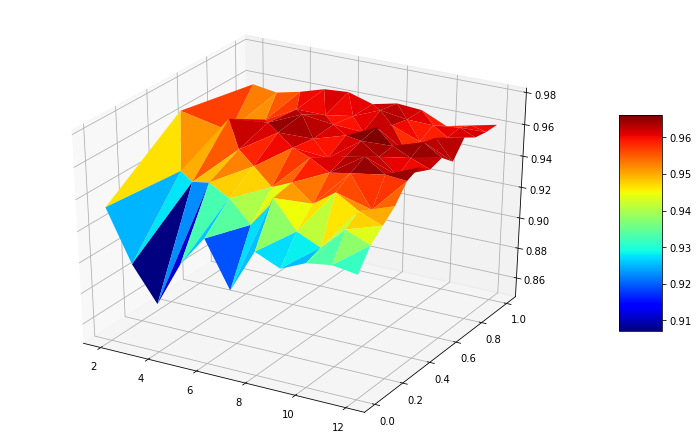

time: 317 ms (started: 2022-01-12 16:28:14 +00:00)


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(cnn_rnn_contour_core["NumOfModels"], cnn_rnn_contour_core["CNN%"], cnn_rnn_contour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.85, 0.98)

plt.show()


In [60]:
fig = go.Figure(data =
    go.Contour(
        z=cnn_rnn_contour_core.Acc,
        x=cnn_rnn_contour_core["NumOfModels"], # horizontal axis
        y=cnn_rnn_contour_core["CNN%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.85,
            end=0.98,
            size=0.005,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Ensemble Test Accuracy using CNN+RNN ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of CNN models"
)

fig.show()


time: 623 ms (started: 2022-01-12 16:28:22 +00:00)


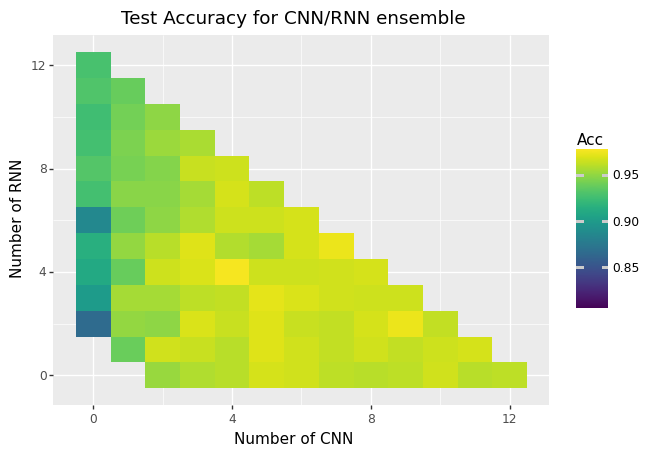

<ggplot: (8774486136669)>

time: 350 ms (started: 2022-01-12 16:31:58 +00:00)


In [65]:
from plotnine import *
ggplot(cnn_rnn_contour, aes(x='NumOfA',y='NumOfB')) + geom_tile(aes(fill='Acc')) + xlab('Number of CNN') + ylab('Number of RNN') + \
ggtitle('Test Accuracy for CNN/RNN ensemble')


# Parallel model with no GP and no collaborative but with different parallel RNN/CNN streams. The _best_ parallel fully integrated model.

function for basic parallel RNN

In [ ]:
def basic_ParallelRNN_A(model_name, inshape, num_classes = 13, num_of_parallels = 2):

  base_input = Input(shape=inshape, name='base_input')
  # f1_output = Flatten(name='F1')(base_input)

  d3rs = []
  for pc in range(num_of_parallels):
    lstm_one = Bidirectional \
        (GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(base_input)
    lstm_two = Bidirectional \
        (GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    attention = SeqWeightedAttention()(lstm_two)
    attention = Flatten()(attention)
    rnnoutput = Dense(256 ,kernel_initializer='RandomNormal', bias_initializer='zeros')(attention)
    rnnoutput = BatchNormalization()(rnnoutput)
    rnnoutput = GaussianNoise(1)(rnnoutput)
    rnnoutput = Dropout(0.4)(rnnoutput)

    # Dense Feed-forward
    dense_one = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros')(rnnoutput)
    dense_one = LeakyReLU()(dense_one)
    dense_one = Dropout(0.5)(dense_one)
    dense_one = BatchNormalization()(dense_one)
    dense_two = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros', name = f'p{pc+1}_LDRNN')(dense_one)
    dense_two = LeakyReLU()(dense_two)
    dense_two = Dropout(0.4)(dense_two)

    # d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1')(f1_output)
    # d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2')(d1_output)
    # d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R')(d2_output)
    d3rs.append(dense_two)

  # merging_layer = tf.keras.layers.concatenate(d3rs)
  concat1_output = Concatenate(name="CONCAT1")(d3rs)
  model_output = Dense(num_classes,  activation='lc0', name = 'SFTMX1')(concat1_output)
  model = Model([base_input], model_output, name = model_name)

  return model


time: 27.2 ms (started: 2022-01-11 14:27:37 +00:00)


In [ ]:
# f"ParallelCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     X_new_train[0,:,:].shape, 
#                     X_new_train, Y_new_train,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'accuracy',
#                     log_history = True,
#                     verbose_level = 1,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(X_val_1000e, Y_val_1000e)

# model_name = f"ParallelCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
# inshape =  X_new_train[0,:,:].shape
# m = basic_ParallelCNN_A(model_name, inshape)
# m.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
#               optimizer=tf.keras.optimizers.Adam(), 
#               metrics=[tf.keras.metrics.CategoricalAccuracy()])
# m.fit(X_new_train, Y_new_train, verbose=1)


function for basic parallel CNN

In [ ]:
def basic_ParallelCNN_A(model_name, inshape, num_classes = 13, num_of_parallels = 2):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  to_merge = []
  for pc in range(num_of_parallels):

    c1 = Conv1D(256 ,10 ,padding='same' ,input_shape=inshape)(base_input)
    b1 = BatchNormalization()(c1)
    lr1 = LeakyReLU(alpha=0.5)(b1)
    mxp1 = MaxPooling1D(2)(lr1)
    gn1 = GaussianNoise(1)(mxp1)  
    drp1 = Dropout(rate=0.5)(gn1)

    c2 = Conv1D(256 ,10 ,padding='same')(drp1)
    b2 = BatchNormalization()(c2)
    lr2 = LeakyReLU(alpha=0.5)(b2)
    mxp2 = MaxPooling1D(4)(lr2)
    gn2 = GaussianNoise(1)(mxp2)  
    drp2 = Dropout(rate=0.5)(gn2)
    
    c3 = Conv1D(256 ,10 ,padding='same')(drp2)
    b3 = BatchNormalization()(c3)
    lr3 = LeakyReLU(alpha=0.5)(b3)
    mxp3 = MaxPooling1D(2)(lr3)
    
    c4 = Conv1D(256 ,10 ,padding='same')(mxp3)
    b4 = BatchNormalization()(c4)
    lr4 = LeakyReLU(alpha=0.5)(b4)
    mxp4 = MaxPooling1D(4)(lr4)
    gn4 = GaussianNoise(1)(mxp4)   
    drp4 = Dropout(rate=0.5)(gn4)

    c5 = Conv1D(256 ,10 ,padding='same')(drp4)
    b5 = BatchNormalization()(c5)
    lr5 = LeakyReLU(alpha=0.5)(b5)
    mxp5 = MaxPooling1D(4)(lr5)
    gn5 = GaussianNoise(1)(mxp5)  
    drp5 = Dropout(rate=0.5)(gn5)
    
    f6 = Flatten()(drp5)

    d7 = Dense(128)(f6)
    b7 = BatchNormalization()(d7)
    lr7 = LeakyReLU(alpha=0.5)(b7)

    d8 = Dense(64, name = f'p{pc+1}_LDCNN')(lr7)
    b8 = BatchNormalization()(d8)
    lr8 = LeakyReLU(alpha=0.5, name = f'p{pc+1}_LlrCNN')(b8)

    to_merge.append(lr8)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 51.3 ms (started: 2022-01-11 14:27:59 +00:00)


function for basic parallel 10 CNN + 10 RNN

In [ ]:
def basic_ParallelCNNRNN_A(model_name, inshape, num_classes = 13, num_of_parallels = 2):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  to_merge = []
  for pc in range(int(num_of_parallels/2)):
    c1 = Conv1D(256 ,10 ,padding='same' ,input_shape=inshape)(base_input)
    b1 = BatchNormalization()(c1)
    lr1 = LeakyReLU(alpha=0.5)(b1)
    mxp1 = MaxPooling1D(2)(lr1)
    gn1 = GaussianNoise(1)(mxp1)  
    drp1 = Dropout(rate=0.5)(gn1)
    c2 = Conv1D(256 ,10 ,padding='same')(drp1)
    b2 = BatchNormalization()(c2)
    lr2 = LeakyReLU(alpha=0.5)(b2)
    mxp2 = MaxPooling1D(4)(lr2)
    gn2 = GaussianNoise(1)(mxp2)  
    drp2 = Dropout(rate=0.5)(gn2)
    c3 = Conv1D(256 ,10 ,padding='same')(drp2)
    b3 = BatchNormalization()(c3)
    lr3 = LeakyReLU(alpha=0.5)(b3)
    mxp3 = MaxPooling1D(2)(lr3)
    c4 = Conv1D(256 ,10 ,padding='same')(mxp3)
    b4 = BatchNormalization()(c4)
    lr4 = LeakyReLU(alpha=0.5)(b4)
    mxp4 = MaxPooling1D(4)(lr4)
    gn4 = GaussianNoise(1)(mxp4)   
    drp4 = Dropout(rate=0.5)(gn4)
    c5 = Conv1D(256 ,10 ,padding='same')(drp4)
    b5 = BatchNormalization()(c5)
    lr5 = LeakyReLU(alpha=0.5)(b5)
    mxp5 = MaxPooling1D(4)(lr5)
    gn5 = GaussianNoise(1)(mxp5)  
    drp5 = Dropout(rate=0.5)(gn5)
    f6 = Flatten()(drp5)
    d7 = Dense(128)(f6)
    b7 = BatchNormalization()(d7)
    lr7 = LeakyReLU(alpha=0.5)(b7)
    d8 = Dense(64, name = f'p{pc+1}_LDCNN')(lr7)
    b8 = BatchNormalization()(d8)
    lr8 = LeakyReLU(alpha=0.5, name = f'p{pc+1}_LlrCNN')(b8)
    to_merge.append(lr8)

  # f1_output = Flatten(name='F1')(base_input)

  for pc in range(int(num_of_parallels/2)):
    lstm_one = Bidirectional \
        (GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(base_input)
    lstm_two = Bidirectional \
        (GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    attention = SeqWeightedAttention()(lstm_two)
    attention = Flatten()(attention)
    rnnoutput = Dense(256 ,kernel_initializer='RandomNormal', bias_initializer='zeros')(attention)
    rnnoutput = BatchNormalization()(rnnoutput)
    rnnoutput = GaussianNoise(1)(rnnoutput)
    rnnoutput = Dropout(0.4)(rnnoutput)

    # Dense Feed-forward
    dense_one = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros')(rnnoutput)
    dense_one = LeakyReLU()(dense_one)
    dense_one = Dropout(0.5)(dense_one)
    dense_one = BatchNormalization()(dense_one)
    dense_two = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros', name = f'p{pc+1}_LDRNN')(dense_one)
    dense_two = LeakyReLU()(dense_two)
    dense_two = Dropout(0.4)(dense_two)

    to_merge.append(dense_two)

    # d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1_DNN')(f1_output)
    # d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2_DNN')(d1_output)
    # d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R_DNN')(d2_output)
    # to_merge.append(d3r_output)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

time: 104 ms (started: 2022-01-11 14:28:04 +00:00)


In [ ]:
X_new_train[0,:,:].shape
X_val_1000e[0,:,:].shape

(1000, 8)

time: 3.72 ms (started: 2022-01-11 14:28:10 +00:00)


In [ ]:
import functools
from functools import partial

time: 809 µs (started: 2022-01-11 14:28:11 +00:00)


In [ ]:
# parallel fuly integrated 20/2 CNN

start_time = timeit.default_timer()
pcnn20, pcnn20h = compile_and_fit_model_basic( partial(basic_ParallelCNN_A, num_of_parallels=20),  
                    f"ParallelCNN_A2_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    X_new_train[0,:,:].shape, 
                    X_new_train, Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 10,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level = 0,                             
                    batch_size=64, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(X_val_1000e, Y_val_1000e))
print(timeit.default_timer()-start_time)
 



In [ ]:
 # parallel fuly integrated 2 RNN

 ## Not Runnable
  
pdnn20, pdnn20h = compile_and_fit_model_basic( basic_ParallelRNN_A,  
                    f"ParallelRNN_A2_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    X_new_train[0,:,:].shape, 
                    X_new_train, Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 10,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=32, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(X_val_1000e, Y_val_1000e))

# /content/drive/MyDrive/data_papers/gpSVHN/model_finals/ParallelDNN_A_20211002170140_saved_model_after_fit/assets  # 88% validation

In [ ]:
# parallel fuly integrated 1 RNN + 1 CNN

start_time = timeit.default_timer()
pdcnn20, pdcnn20h = compile_and_fit_model_basic( basic_ParallelCNNRNN_A,  
                    f"ParallelCNNRNN_A2_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    X_new_train[0,:,:].shape, 
                    X_new_train, Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 10,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level = 0,                             
                    batch_size=32, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(X_val_1000e, Y_val_1000e))
print(timeit.default_timer()-start_time)


In [ ]:
paper_name

'test13'

time: 3.06 ms (started: 2022-01-11 14:28:57 +00:00)


In [ ]:

stored_model_c1r1 = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/ParallelCNNRNN_A2_20211210221624_model_027_0.909/")

pdcnn20, pdcnn20h = compile_and_fit_model_basic( stored_model_c1r1,  
                    stored_model_c1r1.name, 
                    X_new_train[0,:,:].shape, 
                    X_new_train, Y_new_train,
                    save_max_epoch=True,
                    save_final=True,
                    patience_count = 10,
                    early_stopping_obs = 'val_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=32, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(X_val_1000e, Y_val_1000e))

# plot_history(pdnn20h)
# plot_history(pcnn20h)
# plot_history(pdcnn20h)


 the summary results for the fully parallel models

In [ ]:

# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

x_input = X_test_1000e   
y_input = Y_test_1000e

models_to_use = [pdnn20, pcnn20, pdcnn20]
model_predictions = [ np.array(model.predict(x_input), dtype='float64') for model in models_to_use]

y_preds = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions ] 
scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(y_pred, np.apply_along_axis(np.argmax, 1, y_input)) for y_pred in y_preds ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_wrs10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_pdnn20_pcnn20_pdcnn20), 
        allow_pickle=True, 
        fix_imports=True)


In [ ]:
scores_pdnn20_pcnn20_pdcnn20

# Set up the models + features file lists for CNN/RNN splits for reuse test13

In [61]:
acceptable_string_grabs = [ "CNN256_A_", "RNN_A_"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
rnn_model_dirs = [ s for s in model_dirs if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN256" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

rnn_features_files = [ s for s in model_features_files if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN256" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

cnn_identifier = acceptable_string_grabs[0]
rnn_identifier = acceptable_string_grabs[1]

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




time: 435 ms (started: 2022-01-12 16:29:59 +00:00)


# Functions for collaborative learning (no GP) based on last dense and softmax layer features for RNN/CNN inputs

In [66]:
def model_combination_of_features(model_name, input_shape,num_classes=13):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def model_combination_of_features_with_flatten(model_name, input_shape,num_classes=13):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model    


# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)


time: 14.7 ms (started: 2022-01-12 16:34:46 +00:00)


In [67]:
def get_features_from_multiple_models(feature_files, axis_to_concat = 1):
 
  validation_features_to_load = [ff for ff in feature_files if "Validation" in ff and "_X" in ff ]
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

time: 8.37 ms (started: 2022-01-12 16:34:47 +00:00)


In [68]:
def get_features_for_layer(feature_files, layer_name, num_of_models, axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"{layer_name}_" in ff ]
  validation_features_to_load = sorted(random.sample(feature_files_used, min(num_of_models,len(feature_files_used)) ))
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab



time: 10.8 ms (started: 2022-01-12 16:34:47 +00:00)


In [69]:
def get_features_for_layer_order(feature_files, layer_order, num_of_models, axis_to_concat = 1):

  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff ]

  id_matches = [ re.search('.*RNN_A_(\d+_\d+)_features.*_(\d+)_Validation.*', f, re.IGNORECASE) for f in feature_files_used ]
  id_matches = [ (m.group(1),int(m.group(2))) for m in id_matches if m ]
  id_matches_base = list(set([x[0] for x in id_matches]))

  num_models_to_pick = min(num_of_models,len(id_matches_base))
  id_matches_to_load = sorted(random.sample(id_matches_base, num_models_to_pick))

  validation_features_to_load = []
  for id_match in id_matches_to_load:
    validation_features_to_load.extend([ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" in ff ])

  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab


def get_features_for_layer_order_cnn(feature_files, layer_order, num_of_models, axis_to_concat = 1):

  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff ]

  id_matches = [ re.search('.*CNN256_A_(\d+_\d+)_features.*_(\d+)_Validation.*', f, re.IGNORECASE) for f in feature_files_used ]
  id_matches = [ (m.group(1),int(m.group(2))) for m in id_matches if m ]
  id_matches_base = list(set([x[0] for x in id_matches]))

  num_models_to_pick = min(num_of_models,len(id_matches_base))
  id_matches_to_load = sorted(random.sample(id_matches_base, num_models_to_pick))

  validation_features_to_load = []
  for id_match in id_matches_to_load:
    validation_features_to_load.extend([ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" in ff ])

  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab  

time: 71.1 ms (started: 2022-01-12 16:34:47 +00:00)


In [70]:
import random
import re
from collections import defaultdict

def get_base_patterns_for_validation_on_layer_count(features_files, layer_count = 0, layer_name = "dense", model_type = "RNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files ]:
    validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
  id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

  base_pattern_to_layer = defaultdict(list)

  for full_pattern, base_pattern, model_layer_count in id_matches:
    if base_pattern_to_layer[base_pattern]:
      base_pattern_to_layer[base_pattern].append(model_layer_count)
      base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
    else:
      base_pattern_to_layer[base_pattern] = [model_layer_count]

  return [ f"{base_pattern}{layer_name}_{min(layer_numbers)}_" for base_pattern, layer_numbers in base_pattern_to_layer.items()]

time: 14.4 ms (started: 2022-01-12 16:34:47 +00:00)


In [71]:
# get_base_patterns_for_validation_on_layer_count(rnn_features_files, model_type = "CNN256")
# features_files = cnn_features_files
# layer_count = 0
# layer_name = "dense"
# model_type = "CNN256"

# base_patterns_for_validations = []
# for ff in [ s for s in features_files ]:
#   validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
#   if validation_search:
#       base_patterns_for_validations.append(validation_search.group(1))

# base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
# id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
# id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

# base_pattern_to_layer = defaultdict(list)

# for full_pattern, base_pattern, model_layer_count in id_matches:
#   if base_pattern_to_layer[base_pattern]:
#     base_pattern_to_layer[base_pattern].append(model_layer_count)
#     base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
#   else:
#     base_pattern_to_layer[base_pattern] = [model_layer_count]


time: 2.26 ms (started: 2022-01-12 16:34:47 +00:00)


In [72]:
# base_pattern_to_layer
# [ f"{base_pattern}{layer_name}_{min(layer_numbers)}_" for base_pattern, layer_numbers in base_pattern_to_layer.items()]
# get_base_patterns_for_validation_on_layer_count(cnn_features_files, model_type = "CNN256")

time: 635 µs (started: 2022-01-12 16:34:47 +00:00)


In [73]:
# no need to put layer order in, because strings_to_match has already matched the count!!

def get_features_for_layer_from_string(strings_to_match, features_files, num_models_to_pick, axis_to_concat=1):  # layer_order

  feature_files_used = [ff for ff in features_files if "Validation" in ff and "_X" in ff and any([g in ff for g in strings_to_match]) ]
   
  id_matches = [ re.search('.*(\d+_\d+)_features.*_(\d+)_Validation.*', f, re.IGNORECASE) for f in feature_files_used ]
  id_matches = [ (m.group(1),int(m.group(2))) for m in id_matches if m ]
  id_matches_base = list(set([x[0] for x in id_matches]))

  num_models_to_pick = min(num_models_to_pick,len(id_matches_base))
  id_matches_to_load = sorted(random.sample(id_matches_base, num_models_to_pick))

  validation_features_to_load = []
  for id_match in id_matches_to_load:
    # validation_features_to_load.extend([ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" in ff ])
    validation_features_to_load.extend([ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[0]}_Validation_" in ff ])

  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis= axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

  return None


time: 26.3 ms (started: 2022-01-12 16:34:47 +00:00)


In [74]:
# rnn_features_files

time: 450 µs (started: 2022-01-12 16:34:47 +00:00)


# Data for Plot on Collaborative RNN last dense layers

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here
# train_targets.shape
# Y_new_train.shape
# Y_train_1000e.shape

collaborativeFullyC_lc0_data = None

x_input = X_test_1000e
y_input = Y_test_1000e

In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [2,3,4,5,6,7,8,9,10,11,12] # [25,30,35,40,45,50]  #
layer_order = 0

idxCount = 0 if collaborativeFullyC_lc0_data is None else len(collaborativeFullyC_lc0_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_LC{layer_order}_RNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_rnn_lc0, np_y_train_collab_rnn_lc0, np_x_test_collab_rnn_lc0 = get_features_for_layer_order(rnn_features_files, layer_order, mc, axis_to_concat = 1)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_rnn_lc0[0,:].shape, 
                        np_y_train_collab_rnn_lc0, 
                        Y_train_1000e,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_rnn_lc0, Y_val_1000e))
    del np_x_validation_collab_rnn_lc0
    del np_y_train_collab_rnn_lc0
    y_pred_model = np.array(model_here.predict(np_x_test_collab_rnn_lc0), dtype='float64')
    del np_x_test_collab_rnn_lc0
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,np.apply_along_axis(np.argmax, 1, Y_test_1000e))
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lc0_data is None:
      collaborativeFullyC_lc0_data = pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lc0_data = pd.concat([collaborativeFullyC_lc0_data,
                                         pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


In [ ]:
collaborativeFullyC_lc0_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/rnn_collab_test_results_lc0_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Plot on Collaborative RNN softmax layers

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here
# train_targets.shape
# Y_new_train.shape
# Y_train_1000e.shape

collaborativeFullyC_lc1_data = None

x_input = X_test_1000e
y_input = Y_test_1000e

In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [2,3,4,5,6,7,8,9,10,11,12] # [25,30,35,40,45,50]  #
layer_order = 1

idxCount = 0 if collaborativeFullyC_lc1_data is None else len(collaborativeFullyC_lc1_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_LC{layer_order}_RNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_rnn_lc1, np_y_train_collab_rnn_lc1, np_x_test_collab_rnn_lc1 = get_features_for_layer_order(rnn_features_files, layer_order, mc, axis_to_concat = 1)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_rnn_lc1[0,:].shape, 
                        np_y_train_collab_rnn_lc1, 
                        Y_train_1000e,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_rnn_lc1, Y_val_1000e))
    del np_x_validation_collab_rnn_lc1
    del np_y_train_collab_rnn_lc1
    y_pred_model = np.array(model_here.predict(np_x_test_collab_rnn_lc1), dtype='float64')
    del np_x_test_collab_rnn_lc1
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,np.apply_along_axis(np.argmax, 1, Y_test_1000e))
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lc1_data is None:
      collaborativeFullyC_lc1_data = pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lc1_data = pd.concat([collaborativeFullyC_lc1_data,
                                         pd.DataFrame({"Type": "RNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_RNN_A_20211219152718_saved_model_after_fit/assets
2 0 0.919150084154319 0.9184149184149184 0.9175431138154196 0.9184149184149184
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_RNN_A_20211219152734_saved_model_after_fit/assets
3 0 0.9464608159219392 0.9452214452214452 0.9450318427769024 0.9452214452214452
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_RNN_A_20211219152746_saved_model_after_fit/assets
4 0 0.9377300290762157 0.9370629370629371 0.936536229229588 0.9370629370629371
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_RNN_A_20211219152802_saved_model_after_fit/assets
5 0 0.9430570057201512 0.9417249417249417 0.941787145873465 0.9417249417249417
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/mo

In [ ]:
collaborativeFullyC_lc1_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/rnn_collab_test_results_lc1_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



In [ ]:
# cnn_features_files

# Data for Plot on Collaborative CNN last dense layers

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here
# train_targets.shape
# Y_new_train.shape
# Y_train_1000e.shape

collaborativeFullyCcnn_lc0_data = None

x_input = X_test_1000e
y_input = Y_test_1000e

In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [2,3,5,7,10,12,15,18,20,25,30,35,40,50] 
layer_order = 0

idxCount = 0 if collaborativeFullyCcnn_lc0_data is None else len(collaborativeFullyCcnn_lc0_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_LC{layer_order}_CNN256_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_lc0, np_y_train_collab_cnn_lc0, np_x_test_collab_cnn_lc0 = get_features_for_layer_order_cnn(cnn_features_files, layer_order, mc, axis_to_concat = 1)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_cnn_lc0[0,:].shape, 
                        np_y_train_collab_cnn_lc0, 
                        Y_train_1000e,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_lc0, Y_val_1000e))
    del np_x_validation_collab_cnn_lc0
    del np_y_train_collab_cnn_lc0
    y_pred_model = np.array(model_here.predict(np_x_test_collab_cnn_lc0), dtype='float64')
    del np_x_test_collab_cnn_lc0
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,np.apply_along_axis(np.argmax, 1, Y_test_1000e))
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyCcnn_lc0_data is None:
      collaborativeFullyCcnn_lc0_data = pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyCcnn_lc0_data = pd.concat([collaborativeFullyCcnn_lc0_data,
                                         pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC0_CNN256_A_20211219154045_saved_model_after_fit/assets
2 0 0.9560210810551916 0.9522144522144522 0.9529166999487626 0.9522144522144522
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC0_CNN256_A_20211219154056_saved_model_after_fit/assets
3 0 0.9574456779548136 0.9545454545454546 0.9550720978822748 0.9545454545454546
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC0_CNN256_A_20211219154110_saved_model_after_fit/assets
5 0 0.9631895418620217 0.9615384615384616 0.9619287169809277 0.9615384615384616
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC0_CNN256_A_20211219154127_saved_model_after_fit/assets
7 0 0.961770357813689 0.9603729603729604 0.9607276535455632 0.9603729603729604
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_pa

In [ ]:
collaborativeFullyCcnn_lc0_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_test_results_lc0_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Plot on Collaborative CNN softmax layers

In [ ]:
# X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
# X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
# Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here
# train_targets.shape
# Y_new_train.shape
# Y_train_1000e.shape

collaborativeFullyCcnn_lc1_data = None

x_input = X_test_1000e
y_input = Y_test_1000e

In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [2,3,5,7,10,12,15,18,20,25,30,35,40,50] 
layer_order = 1

idxCount = 0 if collaborativeFullyCcnn_lc1_data is None else len(collaborativeFullyCcnn_lc1_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_LC{layer_order}_CNN256_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_lc1, np_y_train_collab_cnn_lc1, np_x_test_collab_cnn_lc1 = get_features_for_layer_order_cnn(cnn_features_files, layer_order, mc, axis_to_concat = 1)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_cnn_lc1[0,:].shape, 
                        np_y_train_collab_cnn_lc1, 
                        Y_train_1000e,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_lc1, Y_val_1000e))
    del np_x_validation_collab_cnn_lc1
    del np_y_train_collab_cnn_lc1
    y_pred_model = np.array(model_here.predict(np_x_test_collab_cnn_lc1), dtype='float64')
    del np_x_test_collab_cnn_lc1
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,np.apply_along_axis(np.argmax, 1, Y_test_1000e))
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyCcnn_lc1_data is None:
      collaborativeFullyCcnn_lc1_data = pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyCcnn_lc1_data = pd.concat([collaborativeFullyCcnn_lc1_data,
                                         pd.DataFrame({"Type": "CNN256", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


In [ ]:
collaborativeFullyCcnn_lc1_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_test_results_lc1_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Contour Plot on Mixed RNN/CNN Collaborative Last Dense Layer

In [ ]:
len(cnn_model_dirs)

101

time: 3.04 ms (started: 2022-01-11 14:30:51 +00:00)


In [ ]:
# wideresnets_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))
rnn_loaded_models = dict(zip(rnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in rnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))

time: 15min 39s (started: 2022-01-11 14:30:54 +00:00)


In [ ]:
x_input = X_test_1000e
y_input = Y_test_1000e


time: 1.02 ms (started: 2022-01-11 14:46:34 +00:00)


In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_contour_data = None

time: 1.06 ms (started: 2022-01-11 14:46:34 +00:00)


In [ ]:
# import random

# total_num_components = [9]

# layer_count = 0
# relevant_cnn_features_files =  get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = layer_count, model_type = "CNN256")
# relevant_rnn_features_files =  get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = layer_count, model_type = "RNN")

# # this is just to get the number out

# for component_count in total_num_components:
#   for num_of_models_cnn in [1]:
#     num_of_models_rnn = component_count - num_of_models_cnn

#     np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
#     np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = (None,None,None)
#     np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

#     if num_of_models_cnn > 0:
#       np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer_from_string(relevant_cnn_features_files, cnn_features_files, num_of_models_cnn) # , layer_count)

#     if num_of_models_rnn > 0:
#       np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = get_features_for_layer_from_string(relevant_rnn_features_files, rnn_features_files, num_of_models_rnn) # , layer_count)
    
#     if num_of_models_cnn > 0 and num_of_models_rnn > 0:        
#       np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_rnn], axis=1)
#       np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_rnn], axis=1)
#       np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_rnn], axis=1)
#     else: 
#       if num_of_models_cnn == 0:
#         np_x_train_collab_wrcdnn = np_x_train_collab_rnn
#         np_x_validation_collab_wrcdnn = np_x_validation_collab_rnn
#         np_x_test_collab_wrcdnn = np_x_test_collab_rnn
#       if num_of_models_rnn == 0:
#         np_x_train_collab_wrcdnn = np_x_train_collab_cnn
#         np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
#         np_x_test_collab_wrcdnn = np_x_test_collab_cnn

    
#     layer_name = f"CL{str(layer_count)}_RL{layer_count}_{str(num_of_models_cnn)}-{str(num_of_models_rnn)}"

#     start_time = timeit.default_timer()
#     model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
#                         f"Collab_LC{layer_count}_CNNRNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                         np_x_train_collab_wrcdnn[0,:].shape, 
#                         np_x_train_collab_wrcdnn, 
#                         Y_train_1000e,
#                         save_max_epoch=False,
#                         save_final=True,
#                         patience_count = 35,
#                         early_stopping_obs = 'val_accuracy',
#                         log_history = True,
#                         verbose_level=0,                             
#                         batch_size=512, 
#                         epochs=250, 
#                         class_weight=None, 
#                         validation_data=(np_x_validation_collab_wrcdnn, Y_val_1000e))
#     print(timeit.default_timer()-start_time)

#     del np_x_train_collab_wrcdnn
#     del np_x_validation_collab_wrcdnn
#     del np_x_validation_collab_cnn
#     del np_x_train_collab_cnn
#     del np_x_validation_collab_rnn
#     del np_x_train_collab_rnn

#     y_pred_model = np.array(model_here.predict(np_x_test_collab_wrcdnn), dtype='float64')
#     del np_x_test_collab_cnn
#     del np_x_test_collab_rnn
#     del np_x_test_collab_wrcdnn

#     y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
#     pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred, np.apply_along_axis(np.argmax, 1, Y_test_1000e))
#     print (num_of_models_cnn, pr, rc, f1, acc)



# layer_count = 0
# relevant_cnn_features_files =  get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = layer_count, model_type = "CNN256")
# relevant_rnn_features_files =  get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = layer_count, model_type = "RNN")


In [ ]:
# set up the data for the WideResnet+CNN collaborative on softmax layer
import random
num_of_repeats = 5
total_num_components = [2,3,4,5,6,7,8,9,10,11,12] 

idxCount = 0 if cnn_dnn_contour_data is None else len(cnn_dnn_contour_data.index)

layer_count = 0
relevant_cnn_features_files =  get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = layer_count, model_type = "CNN256")
relevant_rnn_features_files =  get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = layer_count, model_type = "RNN")

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_rnn = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer_from_string(relevant_cnn_features_files, cnn_features_files, num_of_models_cnn) # , layer_count)

      if num_of_models_rnn > 0:
        np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = get_features_for_layer_from_string(relevant_rnn_features_files, rnn_features_files, num_of_models_rnn) # , layer_count)
      
      if num_of_models_cnn > 0 and num_of_models_rnn > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_rnn], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_rnn], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_rnn], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_rnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_rnn
          np_x_test_collab_wrcdnn = np_x_test_collab_rnn
        if num_of_models_rnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_cnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
          np_x_test_collab_wrcdnn = np_x_test_collab_cnn

      
      layer_name = f"CL{str(layer_count)}_RL{layer_count}_{str(num_of_models_cnn)}-{str(num_of_models_rnn)}"
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_LC{layer_count}_CNNRNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          Y_train_1000e,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_accuracy',
                          log_history = True,
                          verbose_level=1,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, Y_val_1000e))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_rnn
      del np_x_train_collab_rnn

      y_pred_model = np.array(model_here.predict(np_x_test_collab_wrcdnn), dtype='float64')
      del np_x_test_collab_cnn
      del np_x_test_collab_rnn
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred, np.apply_along_axis(np.argmax, 1, Y_test_1000e))
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_dnn_contour_data is None:
        cnn_dnn_contour_data = pd.DataFrame({"TypeA": "CNN256", 
                                                    "TypeB": "RNN", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_rnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_dnn_contour_data = pd.concat([cnn_dnn_contour_data,
                                          pd.DataFrame({"TypeA": "CNN256", 
                                              "TypeB": "RNN", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_rnn, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    


In [ ]:
# print((np_x_train_collab_wrcdnn.shape, np_x_validation_collab_wrcdnn.shape, np_x_test_collab_wrcdnn.shape))
# print((Y_new_train.shape,Y_val_1000e.shape))

((6858, 128), (857, 128), (858, 128))
((7715, 13), (857, 13))


In [ ]:
cnn_dnn_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Contour Plot on Mixed RNN/CNN Collaborative Last Dense Layer



In [75]:
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")

['temp',
 'individual_cnn_summary_20211206214644.npy',
 'individual_rnn_summary_20211207160708.npy',
 'ensemble_rnn_test_results_20211207213341.csv',
 'ensemble_cnn_test_results_20211207215955.csv',
 'cnn_rnn_ensemble_contour_data_20211207233449.csv',
 'cnn_rnn_ensemble_contour_data_20211207235706.csv',
 'rnn_collab_test_results_lc0_20211219152718.csv',
 'rnn_collab_test_results_lc1_20211219153447.csv',
 'cnn_collab_test_results_lc0_20211219154947.csv',
 'cnn_collab_test_results_lc1_20211219155723.csv',
 'cnn_rnn_contour_data_20220103002929.csv',
 'cnn_rnn_sftmx_contour_data_20220105013257.csv']

time: 4.73 ms (started: 2022-01-12 16:35:20 +00:00)


In [76]:
cnn_rnn_contour = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_contour_data_20220103002929.csv")

time: 416 ms (started: 2022-01-12 16:35:22 +00:00)


In [77]:
cnn_rnn_contour

,Unnamed: 0,TypeA,TypeB,Data,NumOfA,NumOfB,RepC,Pr,Rc,F1,Acc
0,0,CNN256,RNN,Test,0,2,0,0.932595,0.931235,0.931402,0.931235
1,1,CNN256,RNN,Test,1,1,0,0.966249,0.965035,0.965363,0.965035
2,2,CNN256,RNN,Test,2,0,0,0.966388,0.965035,0.965340,0.965035
3,3,CNN256,RNN,Test,0,3,0,0.943802,0.942890,0.943022,0.942890
4,4,CNN256,RNN,Test,1,2,0,0.961840,0.960373,0.960682,0.960373
...,...,...,...,...,...,...,...,...,...,...,...
435,435,CNN256,RNN,Test,8,4,4,0.968797,0.968531,0.968520,0.968531
436,436,CNN256,RNN,Test,9,3,4,0.971848,0.970862,0.970939,0.970862
437,437,CNN256,RNN,Test,10,2,4,0.962261,0.961538,0.961704,0.961538
438,438,CNN256,RNN,Test,11,1,4,0.963721,0.962704,0.962985,0.962704


time: 28.6 ms (started: 2022-01-12 16:35:23 +00:00)


In [78]:
cnn_rnn_contour = cnn_rnn_contour.drop_duplicates()
cnn_rnn_contour["NumOfModels"] = cnn_rnn_contour.NumOfA + cnn_rnn_contour.NumOfB
cnn_rnn_contour["Type"] = "CNN_RNN"
cnn_rnn_contour["CNN%"] = cnn_rnn_contour.NumOfA/cnn_rnn_contour["NumOfModels"]

time: 8.26 ms (started: 2022-01-12 16:35:31 +00:00)


In [79]:
cnn_rnn_contour_core = cnn_rnn_contour[["NumOfModels","CNN%","Acc"]].copy()
cnn_rnn_contour_core["NumOfModels"] = cnn_rnn_contour_core["NumOfModels"].astype(float)

time: 3.79 ms (started: 2022-01-12 16:35:32 +00:00)


In [80]:
print(cnn_rnn_contour_core.Acc.min(),cnn_rnn_contour_core.Acc.max())

0.9160839160839158 0.9790209790209792
time: 1.37 ms (started: 2022-01-12 16:35:35 +00:00)


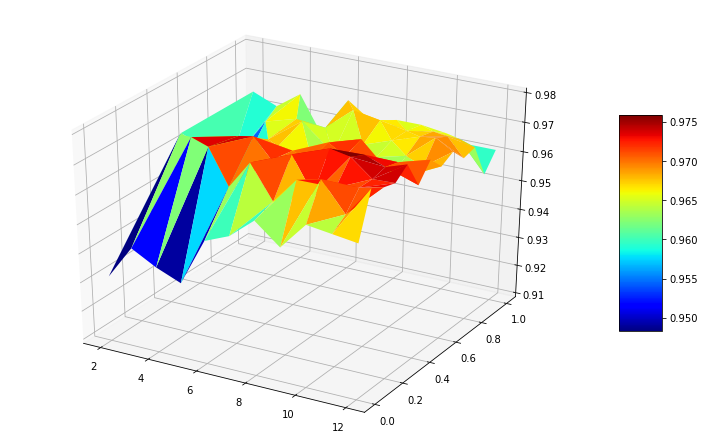

time: 226 ms (started: 2022-01-12 16:35:37 +00:00)


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(cnn_rnn_contour_core["NumOfModels"], cnn_rnn_contour_core["CNN%"], cnn_rnn_contour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.91, 0.98)

plt.show()


In [82]:
fig = go.Figure(data =
    go.Contour(
        z=cnn_rnn_contour_core.Acc,
        x=cnn_rnn_contour_core["NumOfModels"], # horizontal axis
        y=cnn_rnn_contour_core["CNN%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.91,
            end=0.98,
            size=0.005,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Collaborative Test Accuracy Last Dense using CNN+RNN ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of CNN models"
)

fig.show()


time: 130 ms (started: 2022-01-12 16:37:05 +00:00)


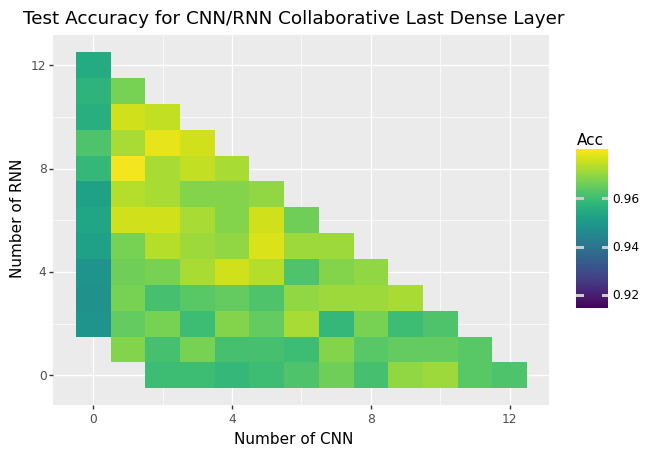

<ggplot: (8774392137877)>

time: 302 ms (started: 2022-01-12 16:39:37 +00:00)


In [84]:
from plotnine import *
ggplot(cnn_rnn_contour, aes(x='NumOfA',y='NumOfB')) + geom_tile(aes(fill='Acc')) + xlab('Number of CNN') + ylab('Number of RNN') + \
ggtitle('Test Accuracy for CNN/RNN Collaborative Last Dense Layer')


# Data for Contour Plot on Mixed RNN/CNN Collaborative Softmax Layer

In [ ]:
rnn_loaded_models = dict(zip(rnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in rnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))

NameError: ignored

In [ ]:
x_input = X_test_1000e
y_input = Y_test_1000e


In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_rnn_sftmx_contour_data = None

In [ ]:
# layer_count

1

In [ ]:
# print(len(relevant_cnn_features_files),len(relevant_rnn_features_files))

# # relevant_rnn_features_files, rnn_features_files, num_of_models_rnn, layer_count

# # def get_features_for_layer_from_string(strings_to_match, features_files, num_models_to_pick, layer_order, axis_to_concat=1):

# strings_to_match = relevant_rnn_features_files
# features_files = rnn_features_files
# num_models_to_pick = num_of_models_rnn
# layer_order = layer_count 
# axis_to_concat=1

# feature_files_used = [ff for ff in features_files if "Validation" in ff and "_X" in ff and any([g in ff for g in strings_to_match]) ]
# id_matches = [ re.search('.*(\d+_\d+)_features.*_(\d+)_Validation.*', f, re.IGNORECASE) for f in feature_files_used ]
# id_matches = [ (m.group(1),int(m.group(2))) for m in id_matches if m ]
# id_matches_base = list(set([x[0] for x in id_matches]))
# num_models_to_pick = min(num_models_to_pick,len(id_matches_base))
# id_matches_to_load = sorted(random.sample(id_matches_base, num_models_to_pick))


100 12


In [ ]:
# print(id_matches_to_load)
# # print(validation_features_to_load)
# print(layer_order)

# validation_features_to_load = []

# id_match = id_matches_to_load[0]
# # ttt = [ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" in ff ]
# print([ ff for ff in feature_files_used if id_match in ff ])
# print([ id_tuple for id_tuple in id_matches])

# print(sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ]))

# # print(f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" )
# # f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[0]}_Validation_" 



In [ ]:

# validation_features_to_load = []
# for id_match in id_matches_to_load:
#    validation_features_to_load.extend([ ff for ff in feature_files_used if id_match in ff and f"_{sorted([ id_tuple[1] for id_tuple in id_matches if id_tuple[0]==id_match ])[layer_order]}_Validation_" in ff ])

# np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
# np_x_validation_collab = np.concatenate(np_x_validation_collab, axis= axis_to_concat)

# train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
# np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
# np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

# test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
# np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
# np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  # return np_x_validation_collab, np_x_train_collab, np_x_test_collab

  # return None



In [ ]:
# set up the data for the WideResnet+CNN collaborative on softmax layer
import random
num_of_repeats = 5
total_num_components = [2,3,4,5,6,7,8,9,10,11,12] 

idxCount = 0 if cnn_rnn_sftmx_contour_data is None else len(cnn_rnn_sftmx_contour_data.index)

layer_count = 1
relevant_cnn_features_files =  get_base_patterns_for_validation_on_layer_count(cnn_features_files, layer_count = layer_count, model_type = "CNN256")
relevant_rnn_features_files =  get_base_patterns_for_validation_on_layer_count(rnn_features_files, layer_count = layer_count, model_type = "RNN")

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_rnn = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer_from_string(relevant_cnn_features_files, cnn_features_files, num_of_models_cnn) # , layer_count)

      if num_of_models_rnn > 0:
        np_x_validation_collab_rnn, np_x_train_collab_rnn, np_x_test_collab_rnn = get_features_for_layer_from_string(relevant_rnn_features_files, rnn_features_files, num_of_models_rnn) # , layer_count)
      
      if num_of_models_cnn > 0 and num_of_models_rnn > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_rnn], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_rnn], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_rnn], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_rnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_rnn
          np_x_test_collab_wrcdnn = np_x_test_collab_rnn
        if num_of_models_rnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_cnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
          np_x_test_collab_wrcdnn = np_x_test_collab_cnn

      
      layer_name = f"CL{str(layer_count)}_RL{layer_count}_{str(num_of_models_cnn)}-{str(num_of_models_rnn)}"
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_LC{layer_count}_CNNRNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          Y_train_1000e,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_accuracy',  # should be val_categorical_accuracy... so no early stopping
                          log_history = True,
                          verbose_level=0,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, Y_val_1000e))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_rnn
      del np_x_train_collab_rnn

      y_pred_model = np.array(model_here.predict(np_x_test_collab_wrcdnn), dtype='float64')
      del np_x_test_collab_cnn
      del np_x_test_collab_rnn
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred, np.apply_along_axis(np.argmax, 1, Y_test_1000e))
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_rnn_sftmx_contour_data is None:
        cnn_rnn_sftmx_contour_data = pd.DataFrame({"TypeA": "CNN256", 
                                                    "TypeB": "RNN", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_rnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_rnn_sftmx_contour_data = pd.concat([cnn_rnn_sftmx_contour_data,
                                          pd.DataFrame({"TypeA": "CNN256", 
                                              "TypeB": "RNN", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_rnn, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    


Streaming output truncated to the last 5000 lines.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_CNNRNN_A_20220105012615_saved_model_after_fit/assets
5 4 0.9688420688633433 0.9673659673659674 0.9676247026981296 0.9673659673659674
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_CNNRNN_A_20220105012635_saved_model_after_fit/assets
6 4 0.9687766555067773 0.9673659673659674 0.9677713725898122 0.9673659673659674
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_CNNRNN_A_20220105012655_saved_model_after_fit/assets
7 4 0.9659664125288459 0.965034965034965 0.9650197386004818 0.965034965034965
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/test13/model_finals/Collab_LC1_CNNRNN_A_20220105012715_saved_model_after_fit/assets
8 4 0.9691085483188658 0.9685314685314685 0.9686400699424756 0.9685314685314685
INFO:tensorflow

In [ ]:
# print((np_x_train_collab_wrcdnn.shape, np_x_validation_collab_wrcdnn.shape, np_x_test_collab_wrcdnn.shape))
# print((Y_new_train.shape,Y_val_1000e.shape))

((6858, 128), (857, 128), (858, 128))
((7715, 13), (857, 13))


In [ ]:
cnn_rnn_sftmx_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_sftmx_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Contour Plot on Mixed RNN/CNN Collaborative Softmax Layer



In [85]:
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")

['temp',
 'individual_cnn_summary_20211206214644.npy',
 'individual_rnn_summary_20211207160708.npy',
 'ensemble_rnn_test_results_20211207213341.csv',
 'ensemble_cnn_test_results_20211207215955.csv',
 'cnn_rnn_ensemble_contour_data_20211207233449.csv',
 'cnn_rnn_ensemble_contour_data_20211207235706.csv',
 'rnn_collab_test_results_lc0_20211219152718.csv',
 'rnn_collab_test_results_lc1_20211219153447.csv',
 'cnn_collab_test_results_lc0_20211219154947.csv',
 'cnn_collab_test_results_lc1_20211219155723.csv',
 'cnn_rnn_contour_data_20220103002929.csv',
 'cnn_rnn_sftmx_contour_data_20220105013257.csv']

time: 4.85 ms (started: 2022-01-12 16:51:45 +00:00)


In [86]:
cnn_rnn_contour = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_sftmx_contour_data_20220105013257.csv")

time: 399 ms (started: 2022-01-12 16:52:15 +00:00)


In [87]:
cnn_rnn_contour

,Unnamed: 0,TypeA,TypeB,Data,NumOfA,NumOfB,RepC,Pr,Rc,F1,Acc
0,0,CNN256,RNN,Test,0,2,0,0.936059,0.935897,0.935583,0.935897
1,1,CNN256,RNN,Test,1,1,0,0.972706,0.972028,0.972219,0.972028
2,2,CNN256,RNN,Test,2,0,0,0.958716,0.956876,0.957346,0.956876
3,3,CNN256,RNN,Test,0,3,0,0.946451,0.945221,0.945206,0.945221
4,4,CNN256,RNN,Test,1,2,0,0.960008,0.958042,0.958471,0.958042
...,...,...,...,...,...,...,...,...,...,...,...
435,435,CNN256,RNN,Test,8,4,4,0.970545,0.968531,0.968884,0.968531
436,436,CNN256,RNN,Test,9,3,4,0.969472,0.968531,0.968681,0.968531
437,437,CNN256,RNN,Test,10,2,4,0.966569,0.965035,0.965371,0.965035
438,438,CNN256,RNN,Test,11,1,4,0.964078,0.962704,0.962899,0.962704


time: 25.9 ms (started: 2022-01-12 16:52:18 +00:00)


In [88]:
cnn_rnn_contour = cnn_rnn_contour.drop_duplicates()
cnn_rnn_contour["NumOfModels"] = cnn_rnn_contour.NumOfA + cnn_rnn_contour.NumOfB
cnn_rnn_contour["Type"] = "CNN_RNN"
cnn_rnn_contour["CNN%"] = cnn_rnn_contour.NumOfA/cnn_rnn_contour["NumOfModels"]

time: 7.9 ms (started: 2022-01-12 16:52:32 +00:00)


In [89]:
cnn_rnn_contour_core = cnn_rnn_contour[["NumOfModels","CNN%","Acc"]].copy()
cnn_rnn_contour_core["NumOfModels"] = cnn_rnn_contour_core["NumOfModels"].astype(float)

time: 4.27 ms (started: 2022-01-12 16:52:34 +00:00)


In [90]:
print(cnn_rnn_contour_core.Acc.min(),cnn_rnn_contour_core.Acc.max())

0.8881118881118881 0.98018648018648
time: 1.47 ms (started: 2022-01-12 16:52:36 +00:00)


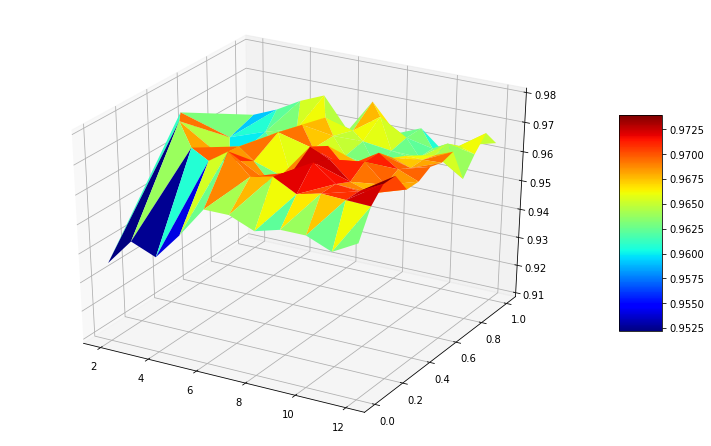

time: 250 ms (started: 2022-01-12 16:52:56 +00:00)


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(cnn_rnn_contour_core["NumOfModels"], cnn_rnn_contour_core["CNN%"], cnn_rnn_contour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.91, 0.98)

plt.show()


In [92]:
fig = go.Figure(data =
    go.Contour(
        z=cnn_rnn_contour_core.Acc,
        x=cnn_rnn_contour_core["NumOfModels"], # horizontal axis
        y=cnn_rnn_contour_core["CNN%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.91,
            end=0.98,
            size=0.005,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Collaborative Test Accuracy Softmax using CNN+RNN ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of CNN models"
)

fig.show()


time: 133 ms (started: 2022-01-12 16:55:57 +00:00)


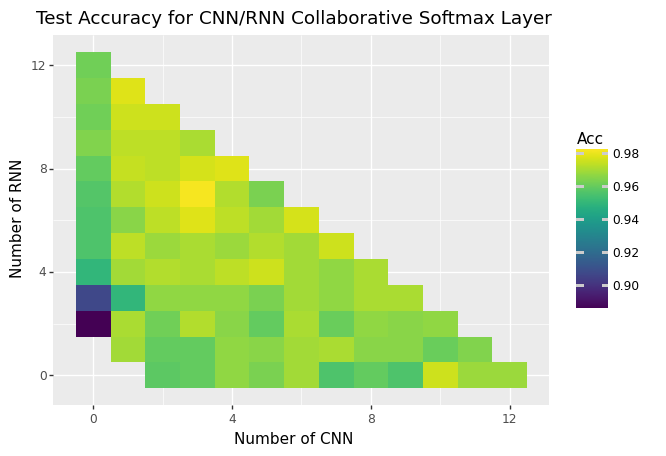

<ggplot: (8774391930237)>

time: 317 ms (started: 2022-01-12 16:57:38 +00:00)


In [93]:
from plotnine import *
ggplot(cnn_rnn_contour, aes(x='NumOfA',y='NumOfB')) + geom_tile(aes(fill='Acc')) + xlab('Number of CNN') + ylab('Number of RNN') + \
ggtitle('Test Accuracy for CNN/RNN Collaborative Softmax Layer')
